## Development space for CoinciERAvie:

for those wondering: its a mix of the words coincidence - ERA5 and a joke on the Micheal Cera CeraVe ad



In [1]:
import xarray as xr
import numpy as np

path = "/gws/nopw/j04/global_ex/data/"

d_daily = xr.open_zarr(
    path + "era5.zarr",
    chunks={}, 
    consolidated=True, use_cftime=True
)
d_daily = d_daily.rename({"latitude": "lat", "longitude": "lon"})

/tmp/ipykernel_2280422/2612289597.py:6: DeprecationWarning: Usage of 'use_cftime' as a kwarg is deprecated. Please pass a 'CFDatetimeCoder' instance initialized with 'use_cftime' to the 'decode_times' kwarg instead.
Example usage:
    time_coder = xr.coders.CFDatetimeCoder(use_cftime=True)
    ds = xr.open_dataset(decode_times=time_coder)

  d_daily = xr.open_zarr(


---
### Section 1: figuring out how to do a running window extreme temp thing

- This code looks at a wholistic basis (not breaking things up month by month or season by season)
- runs a 5 year centered window
- within window it compute quantiles as thresholds
- then within the window finds the mean of days exceeding said threshold for each quantile of temperature

**Next Steps**
- be able to compute other values for these extreme days


In [99]:
# Select a small latitude band and a single longitude
T = d_daily.t2m.isel(lat=slice(340, 360), lon=500)
CAPE = d_daily.cape.isel(lat=slice(340, 360), lon=500)

window = 5 * 365
qvals = [0.1, 0.3, 0.5, 0.75, 0.9, 0.95, 0.97, 0.99]

# --- 1. Rolling window over time ---------------------------------------------
Troll = T.rolling(time=window, center=True, min_periods=1).construct("window")
# Troll dims: (time, lat, window)

# --- 2. Rolling thresholds -----------------------------------------------------
thresholds = (
    Troll.quantile(qvals, dim="window")
         .assign_coords(quantile=qvals)
)
# thresholds dims: (quantile, time, lat)

# --- 3. Broadcast temperature & thresholds to same dimensions -----------------

# Expand Troll: (time, lat, window) → (quantile, time, lat, window)
Troll4 = Troll.expand_dims(quantile=qvals)

# Expand thresholds: (quantile, time, lat) → (quantile, time, lat, window)
thr4 = thresholds.expand_dims(window=Troll.window)

# --- 4. Mask days exceeding threshold -----------------------------------------
mask = Troll4 > thr4  # dims: (quantile, time, lat, window)

# --- 5. Mean temperature of exceedance days -----------------------------------
T_exceed = Troll4.where(mask).mean("window")

# --- 6. Mean CAPE on the same exceedance days --------------------------------
# Broadcast CAPE to same dims as Troll4
CAPEroll = CAPE.rolling(time=window, center=True).construct("window")
CAPEroll4 = CAPEroll.expand_dims(quantile=qvals)

# Use the *same mask* to get CAPE on exceedance days
CAPE_exceed = CAPEroll4.where(mask).mean("window")

# --- 7. Results ---------------------------------------------------------------
# T_exceed dims:      (quantile, time, lat)
# CAPE_exceed dims:   (quantile, time, lat)


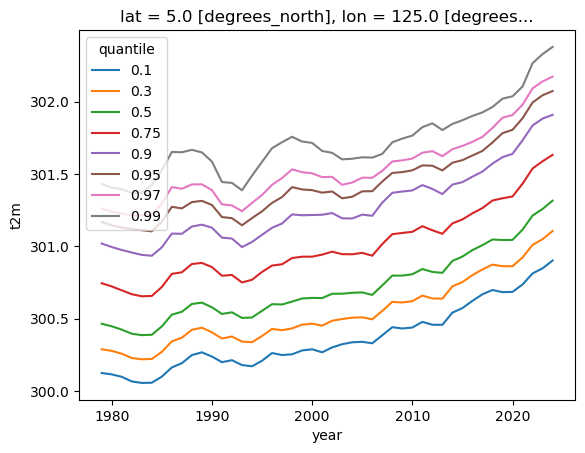

In [100]:
T_exceed.isel(lat = 0).groupby('time.year').mean('time').plot(hue="quantile")


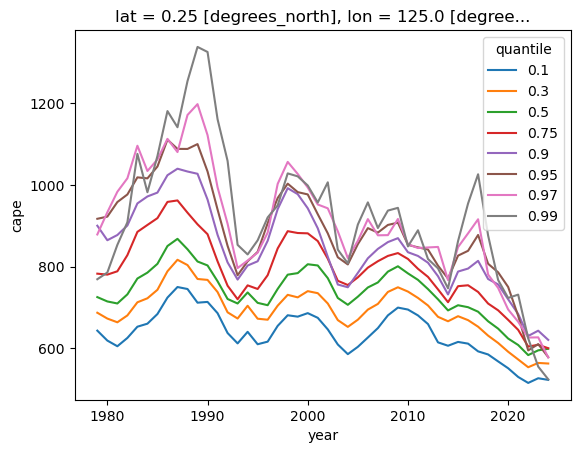

In [106]:
CAPE_exceed.isel(lat = -1).groupby('time.year').mean('time').plot(hue="quantile")


In [105]:
T_exceed.isel(lat = 0, quantile=0).values

array([300.12222, 300.122  , 300.12213, ..., 300.9652 , 300.96606,
       300.9659 ], shape=(16802,), dtype=float32)

---
### Section 2: JHM - joint histogram maker


In [131]:
reqDims = ['time', 'lat', 'lon']
ignoreDims = ['level']

analysis_vars = []
for var in d_daily.variables:

    if d_daily[var].dims == tuple(reqDims):
        print(f"{var} has required dims {reqDims}")
        analysis_vars.append(var)
    elif any(dim in d_daily[var].dims for dim in ignoreDims):
        print(f"{var} has ignored dims {ignoreDims}")
    else:
        print(f"{var} does not have required dims {reqDims}")

blh has required dims ['time', 'lat', 'lon']
cape has required dims ['time', 'lat', 'lon']
cc has ignored dims ['level']
cin has required dims ['time', 'lat', 'lon']
ciwc has ignored dims ['level']
clwc has ignored dims ['level']
d2m has required dims ['time', 'lat', 'lon']
hcc has required dims ['time', 'lat', 'lon']
ie has required dims ['time', 'lat', 'lon']
lcc has required dims ['time', 'lat', 'lon']
lsm has required dims ['time', 'lat', 'lon']
lsrr has required dims ['time', 'lat', 'lon']
mcc has required dims ['time', 'lat', 'lon']
mcpr has required dims ['time', 'lat', 'lon']
mer has required dims ['time', 'lat', 'lon']
mlspr has required dims ['time', 'lat', 'lon']
mper has required dims ['time', 'lat', 'lon']
mror has required dims ['time', 'lat', 'lon']
mslhf has required dims ['time', 'lat', 'lon']
msnlwrf has required dims ['time', 'lat', 'lon']
msnlwrfcs has required dims ['time', 'lat', 'lon']
msnswrf has required dims ['time', 'lat', 'lon']
msnswrfcs has required dims [

Processing variable: blh


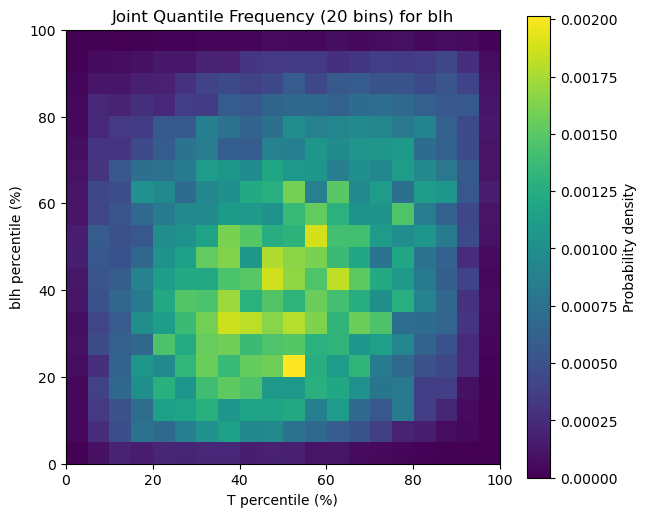

Processing variable: cape


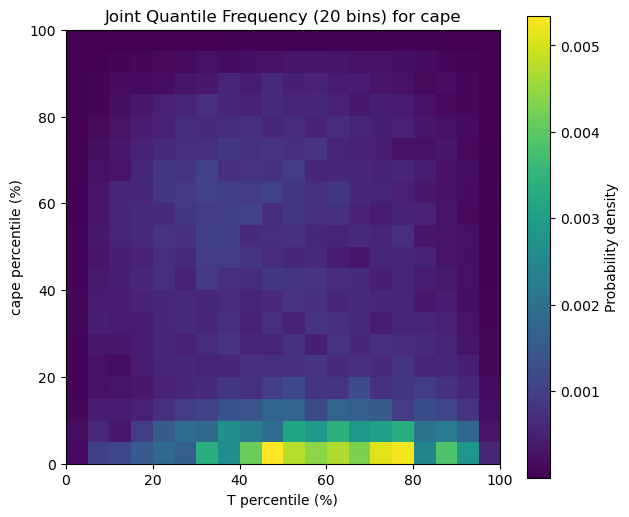

Processing variable: cin


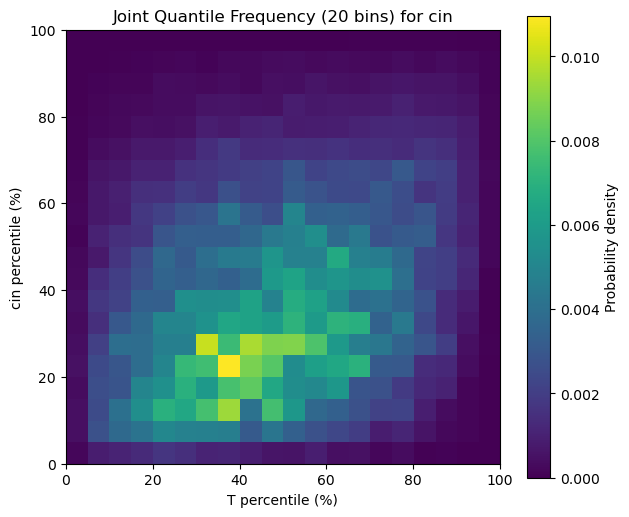

Processing variable: d2m


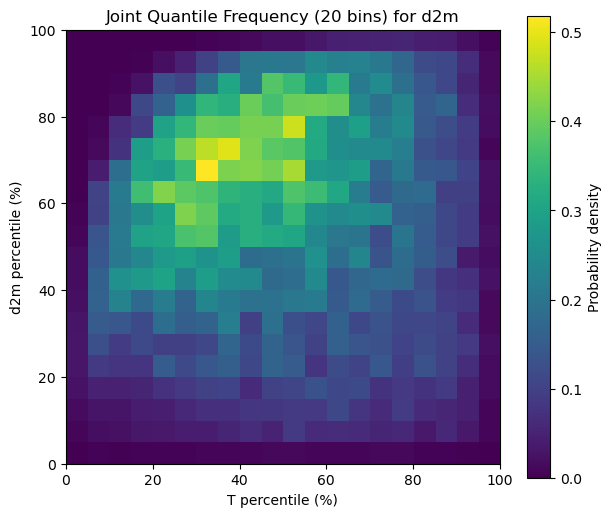

Processing variable: hcc
Not enough data points for variable hcc, skipping.
Processing variable: ie
Not enough data points for variable ie, skipping.
Processing variable: lcc
Not enough data points for variable lcc, skipping.
Processing variable: lsm


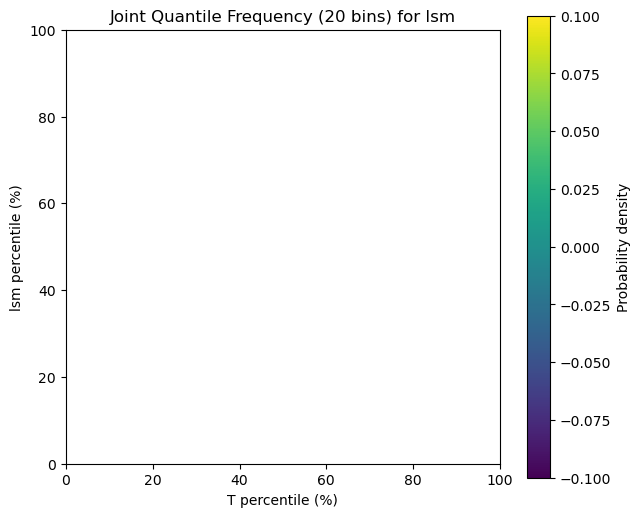

Processing variable: lsrr
Not enough data points for variable lsrr, skipping.
Processing variable: mcc
Not enough data points for variable mcc, skipping.
Processing variable: mcpr


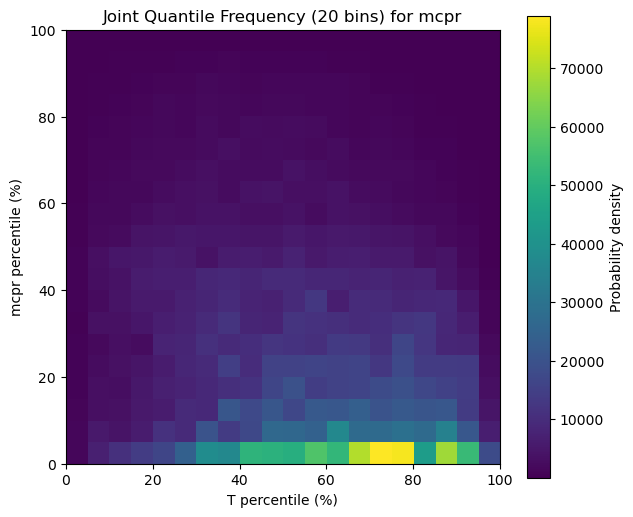

Processing variable: mer


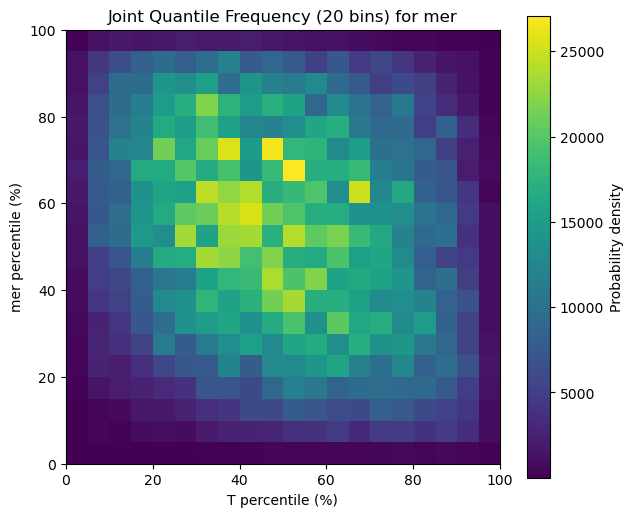

Processing variable: mlspr


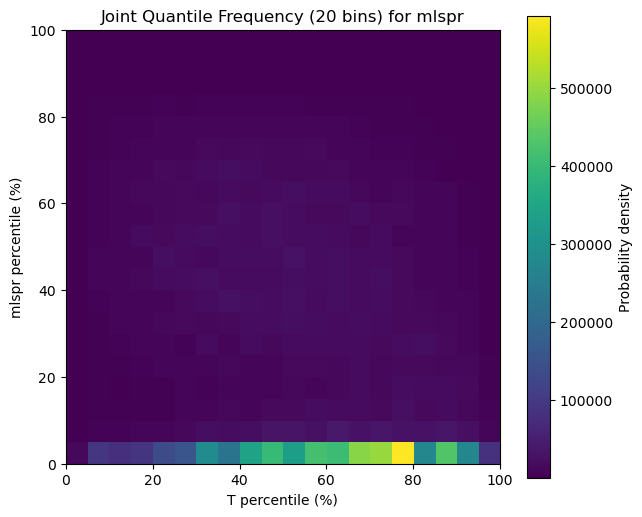

Processing variable: mper
Not enough data points for variable mper, skipping.
Processing variable: mror
Not enough data points for variable mror, skipping.
Processing variable: mslhf


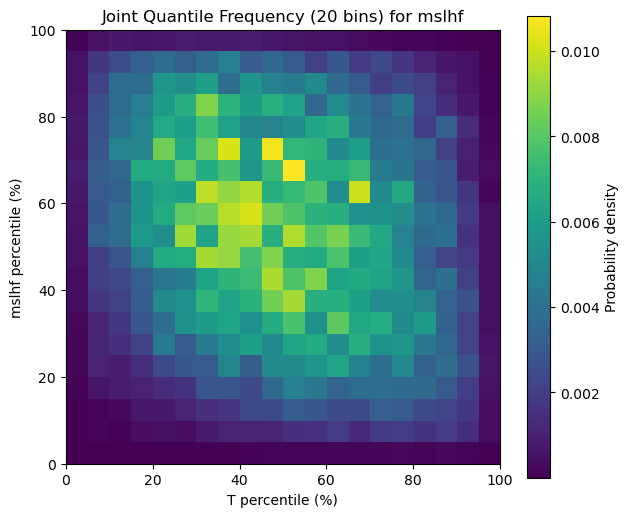

Processing variable: msnlwrf


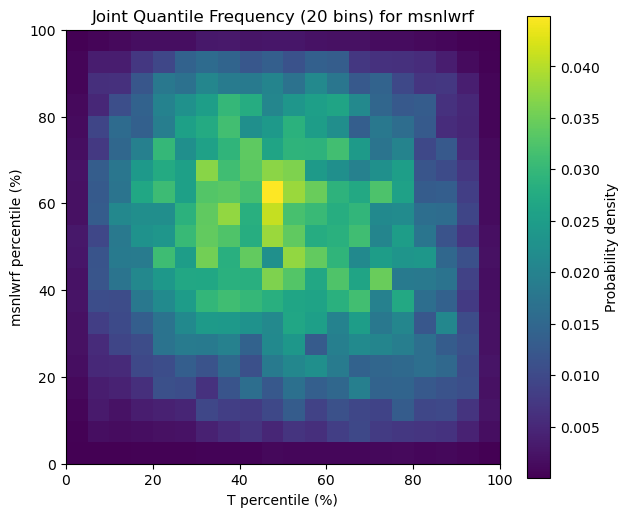

Processing variable: msnlwrfcs


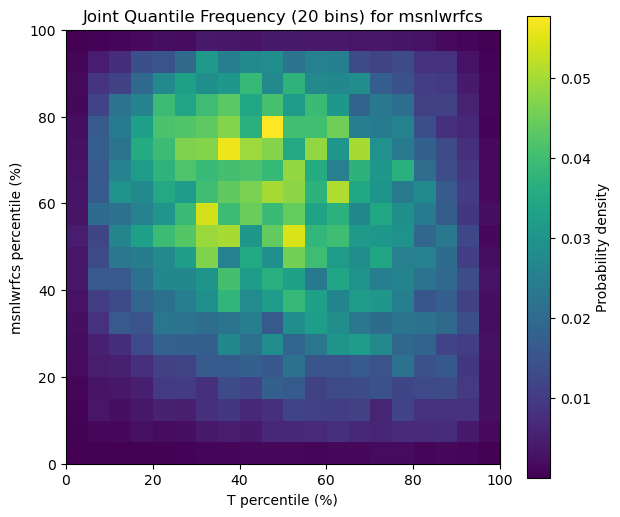

Processing variable: msnswrf


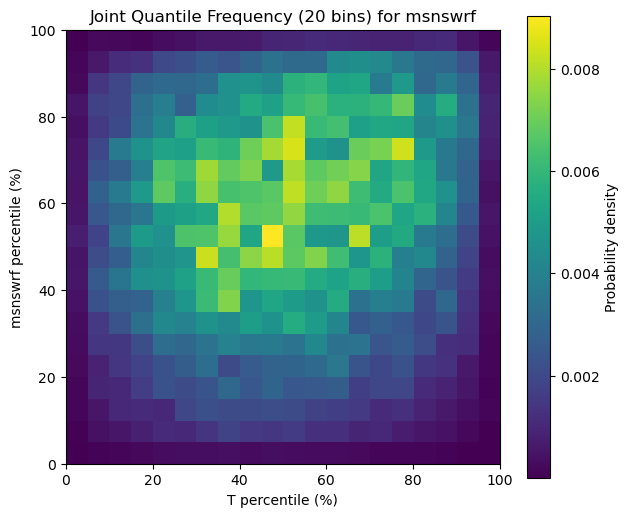

Processing variable: msnswrfcs
Not enough data points for variable msnswrfcs, skipping.
Processing variable: msror
Not enough data points for variable msror, skipping.
Processing variable: msshf


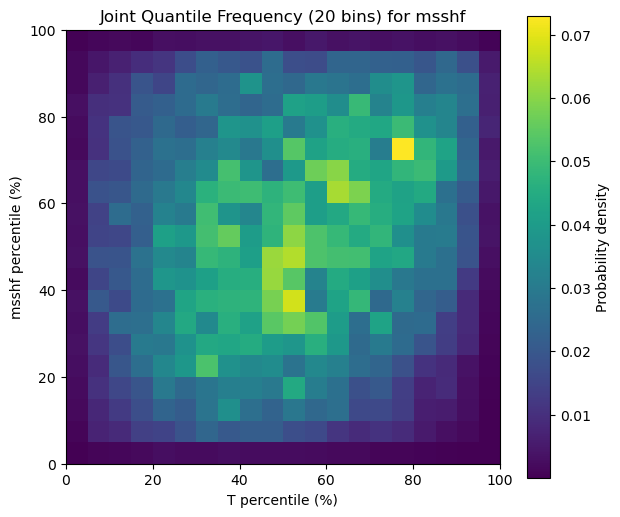

Processing variable: mtnlwrf


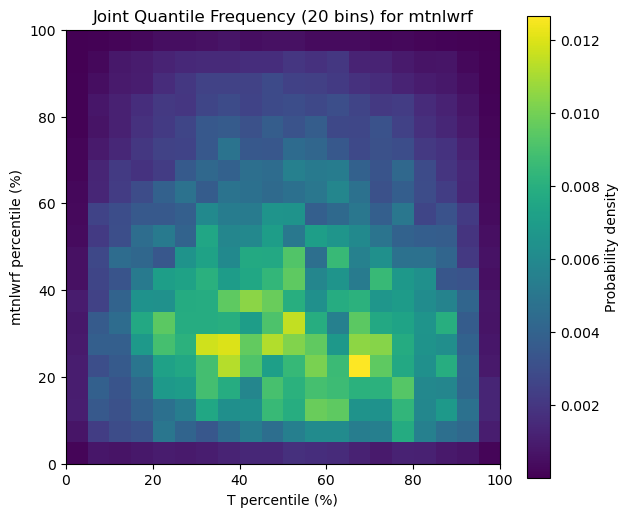

Processing variable: mtnlwrfcs


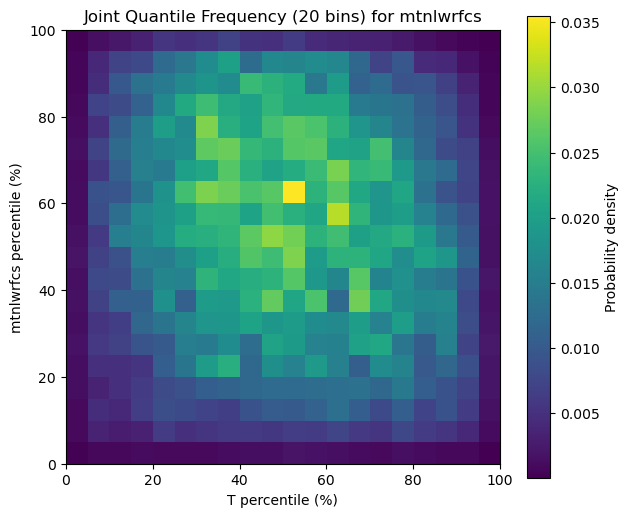

Processing variable: mtnswrf


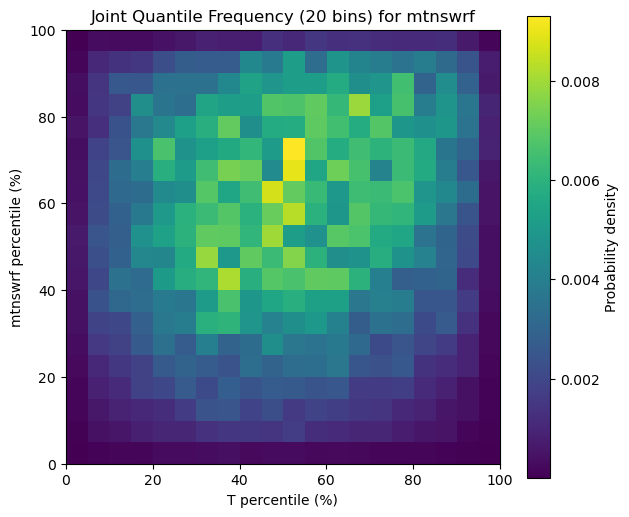

Processing variable: mtnswrfcs


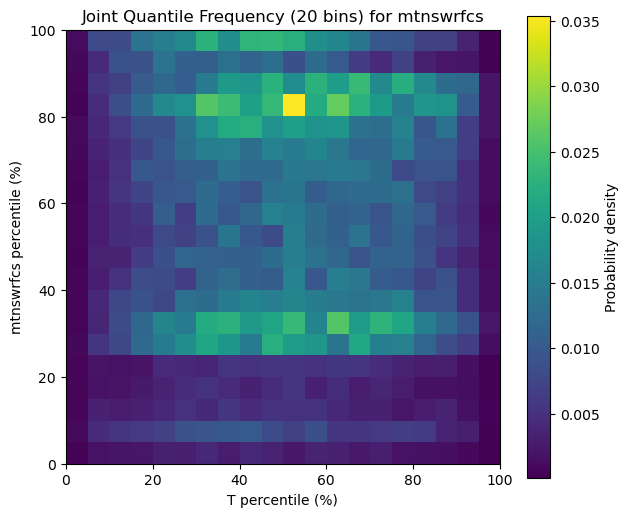

Processing variable: mtpr


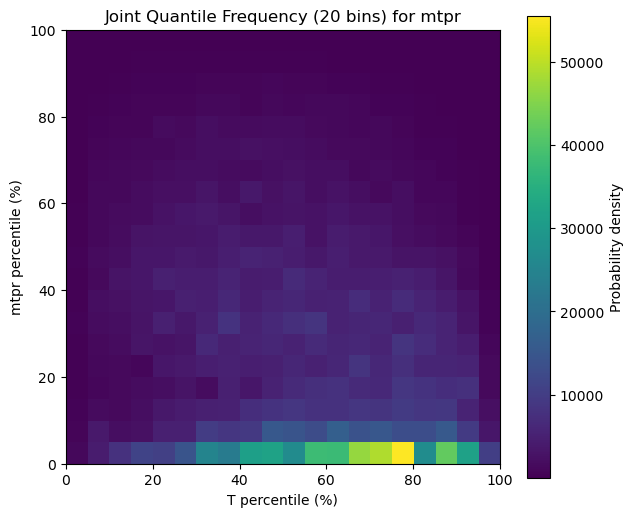

Processing variable: mvimd


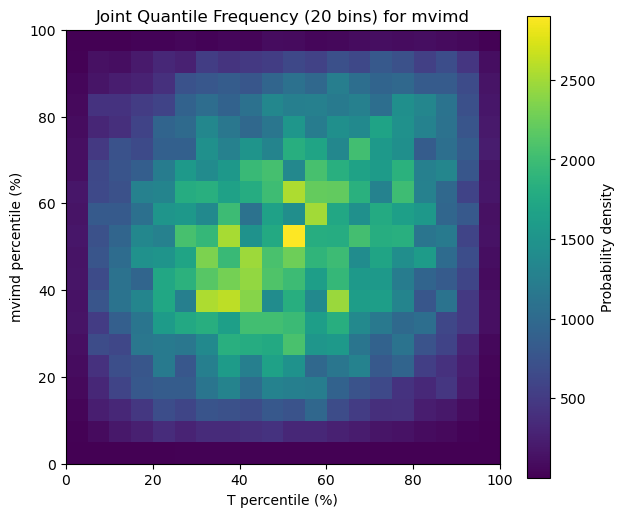

Processing variable: q2m


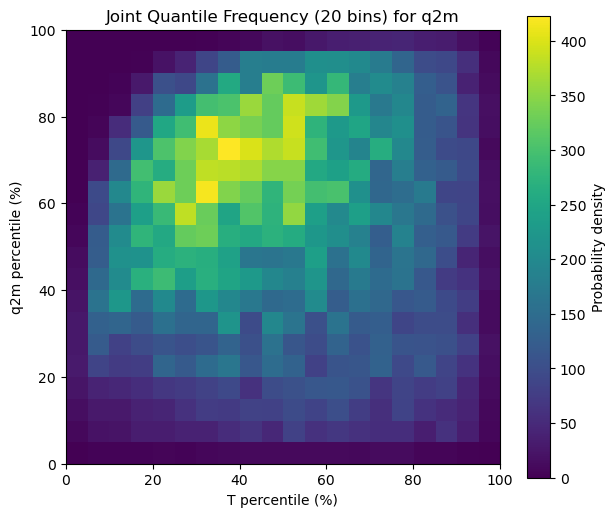

Processing variable: skt
Not enough data points for variable skt, skipping.
Processing variable: slt
Not enough data points for variable slt, skipping.
Processing variable: sp


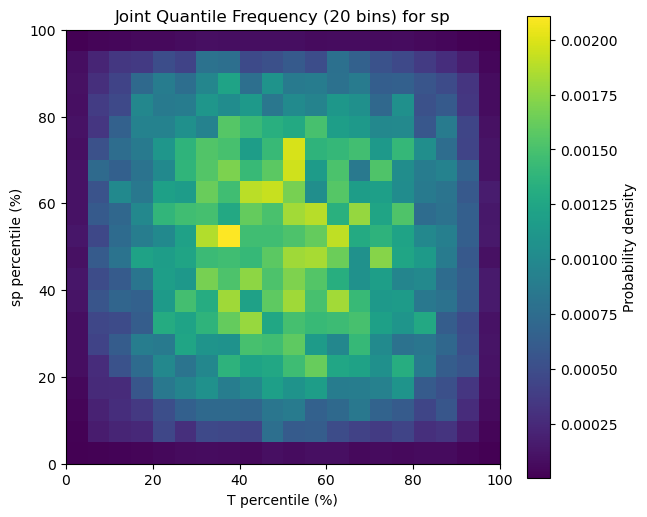

Processing variable: sst
Not enough data points for variable sst, skipping.
Processing variable: swvl1
Not enough data points for variable swvl1, skipping.
Processing variable: swvl2
Not enough data points for variable swvl2, skipping.
Processing variable: swvl3
Not enough data points for variable swvl3, skipping.
Processing variable: t2m


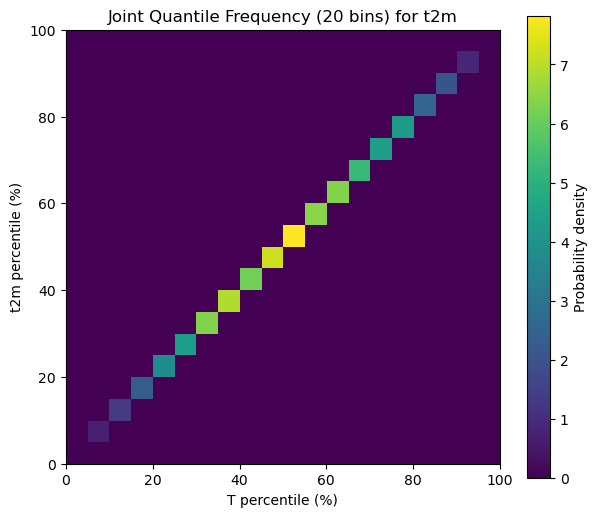

Processing variable: tcc


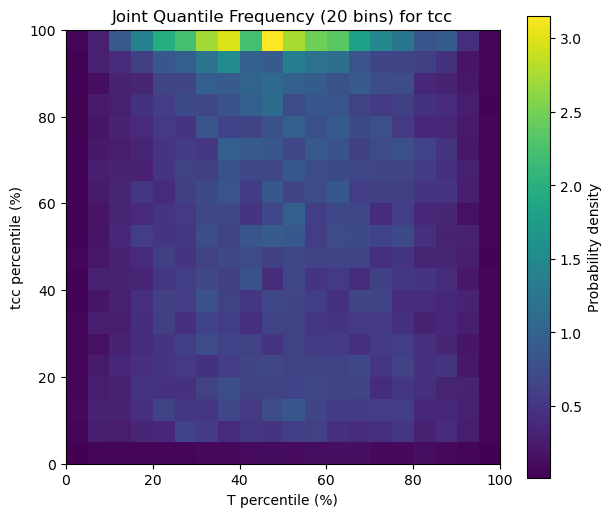

Processing variable: tciw


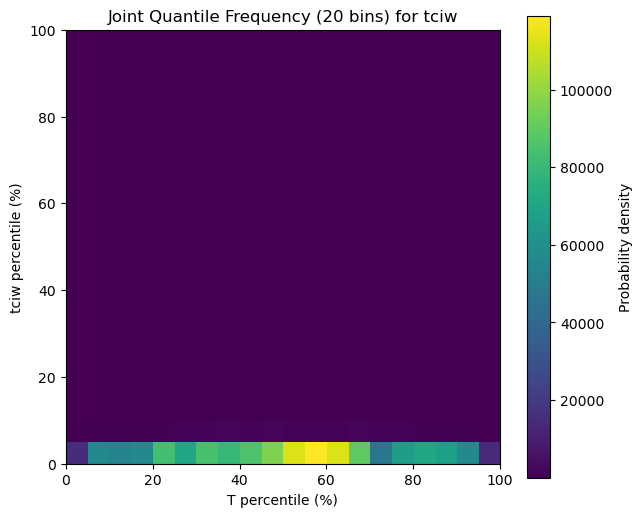

Processing variable: tclw


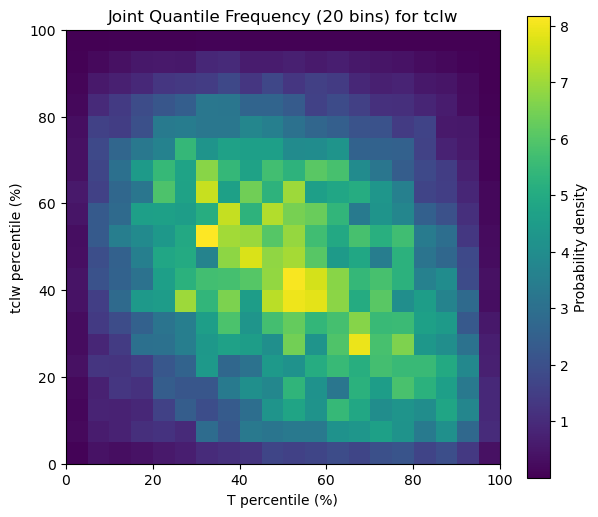

Processing variable: tcrw
Not enough data points for variable tcrw, skipping.
Processing variable: tcsw
Not enough data points for variable tcsw, skipping.
Processing variable: tcw
Not enough data points for variable tcw, skipping.
Processing variable: tcwv


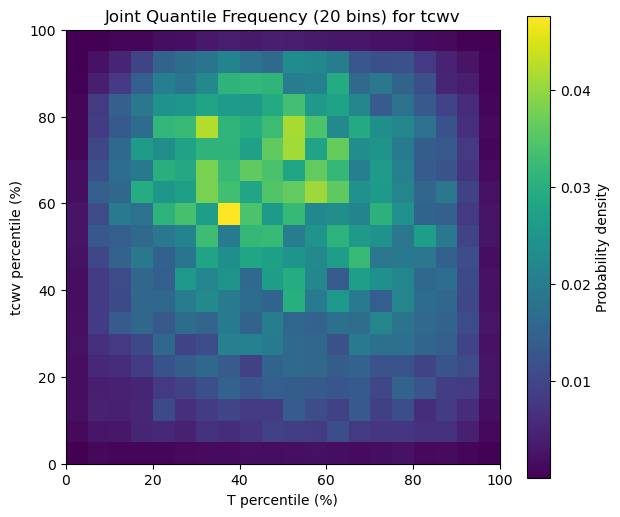

Processing variable: u10


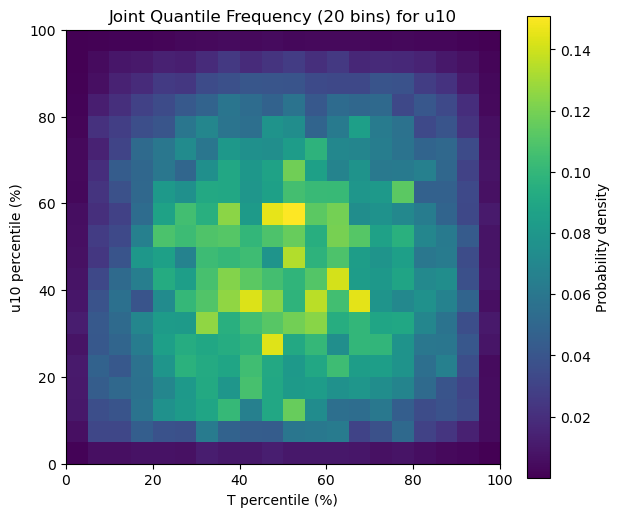

Processing variable: v10


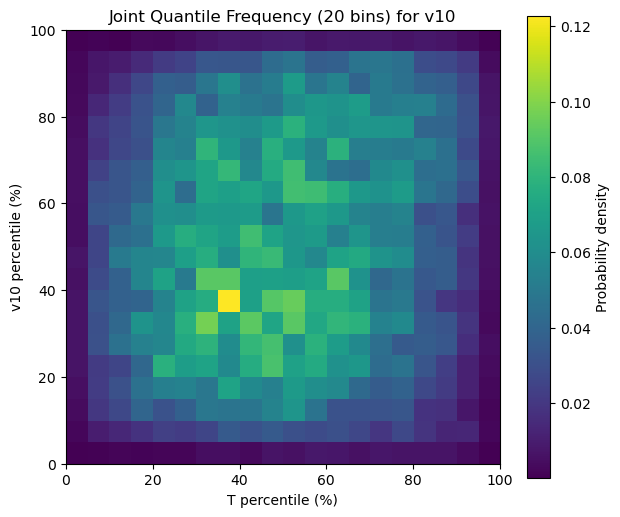

Processing variable: viiw


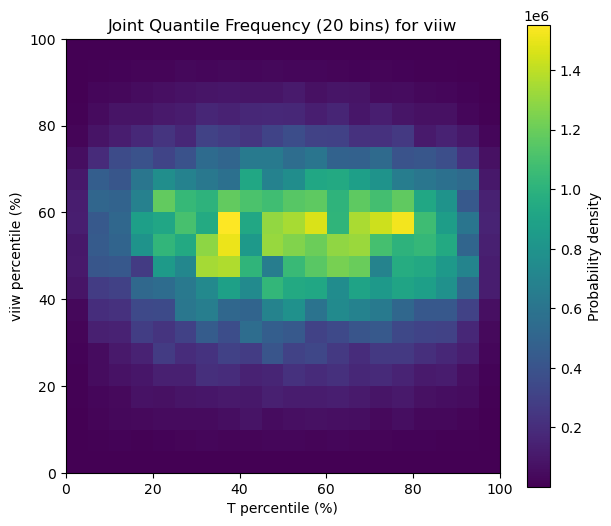

Processing variable: vilw


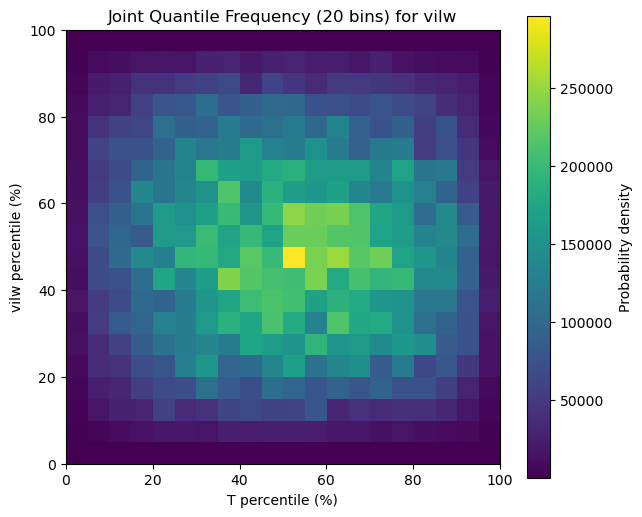

Processing variable: vimdf


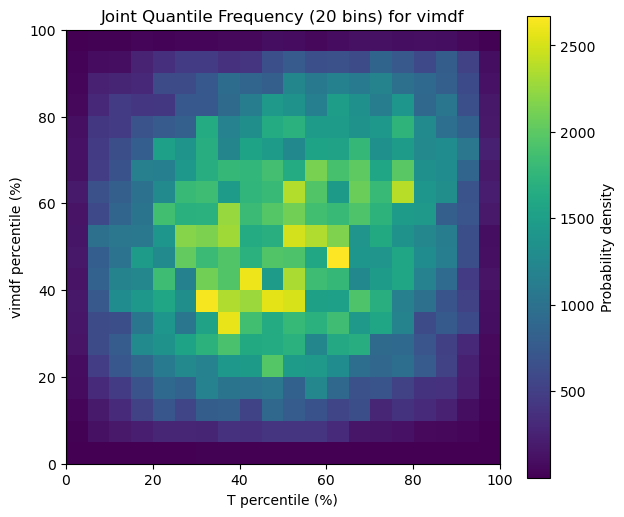

Processing variable: z_sfc


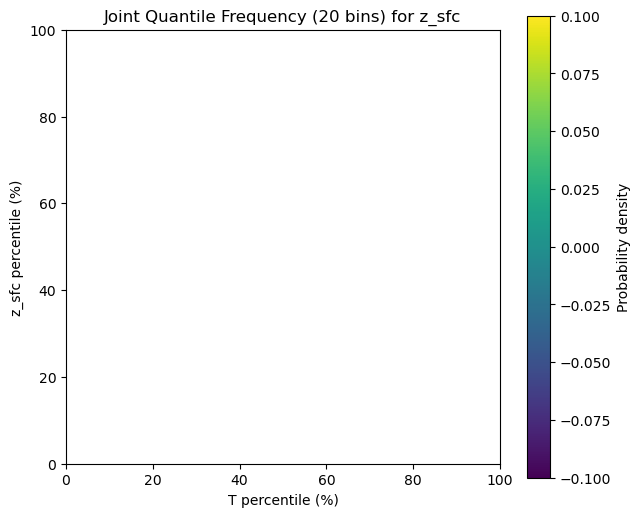

In [134]:
import matplotlib.pyplot as plt
lat, lon = 340, 800

# Flatten data
for var in analysis_vars:
    print(f"Processing variable: {var}")
    T_flat = d_daily.t2m.isel(lat=lat, lon=lon).values.flatten()
    y_flat = d_daily[var].isel(lat=lat, lon=lon).values.flatten()

    # Remove NaNs
    mask = ~np.isnan(T_flat) & ~np.isnan(y_flat)
    T_flat = T_flat[mask]
    y_flat = y_flat[mask]

    # Ensure there are enough data points
    if len(T_flat) < 100:
        print(f"Not enough data points for variable {var}, skipping.")
        continue
    # Define percentile edges for 20 bins (0%, 5%, ..., 100%)
    nBins = 20
    percentiles = np.linspace(0, 100, nBins + 1)
    T_edges = np.percentile(T_flat, percentiles)
    y_edges = np.percentile(y_flat, percentiles)

    # Compute 2D histogram (joint frequency in quantile bins)
    hist, _, _ = np.histogram2d(T_flat, y_flat, bins=[T_edges, y_edges], density=True)

    # Plot
    plt.figure(figsize=(7,6))
    plt.imshow(hist.T, origin='lower', aspect='equal',
            extent=[0,100,0,100],  # axes in percentiles
            cmap='viridis')
    plt.colorbar(label='Probability density')
    plt.xlabel('T percentile (%)')
    plt.ylabel(f'{var} percentile (%)')
    plt.title(f'Joint Quantile Frequency ({nBins} bins) for {var}')
    plt.show()

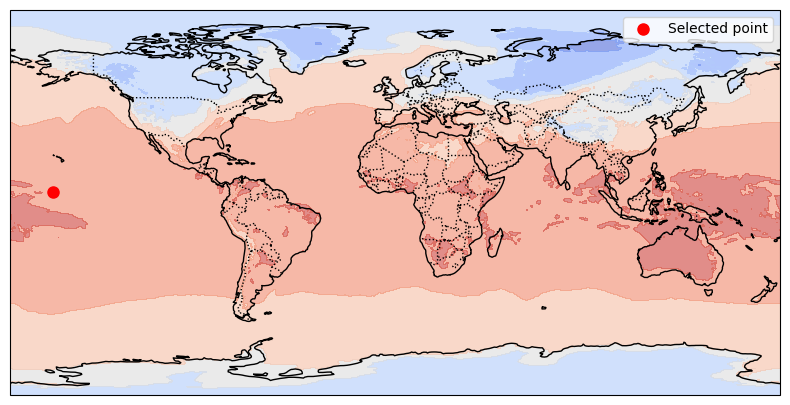

In [128]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Get the actual lat/lon values from your dataset
lat_value = d_daily.lat.isel(lat=340).values
lon_value = d_daily.lon.isel(lon=800).values 
lon_value = (lon_value + 180) % 360 - 180

# Create a map
plt.figure(figsize=(10,5))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
ax.add_feature(cfeature.BORDERS, linestyle=':')
plt.contourf(d_daily.lon, d_daily.lat, d_daily.t2m.isel(time=0), 
             transform=ccrs.PlateCarree(), cmap='coolwarm', alpha=0.6)

# Plot the point
ax.plot(lon_value, lat_value, 'ro', markersize=8, label='Selected point')
plt.legend()
plt.show()

In [ ]:
# conver to -180, 180, 
lon_value = (lon_value + 180) % 360 - 180

np.float32(200.0)